## README
1. Get SNOOP File
To receive the HCI_Snoop File, launch the pullSnoop bash file in the hci_logs directory  
or  
use "adb pull /data/log/bt/"
2. Analyse SNOOP File  
Open collected logs with wireshark.
3. Apply Filter
Apply Filter if exists or type own filter like:  
(bluetooth.src == c4:9f:4c:27:59:79) || (bluetooth.src == 24:0a:c4:61:78:d2) || (bluetooth.dst == 24:0a:c4:61:78:d2)||(bluetooth.dst == c4:9f:4c:27:59:79)
4. Show app log file  
Drag the log file from the app into the share folder, or copy the content into a new file in the share folder  
5. Analyze log file  
Use the Notebook below to analyze the app logs and to find time stamps to compare with the HCI_Snoop File  



In [200]:
import pandas as pd
import pprint
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [38]:
columns = ["time","priority","class","message","extra"]
date = "2021-03-16"
filename_app = date+".log"
filename_hci = "hci-"+date+".csv"

#### Read App logs

In [39]:
open_file = open(filename_app,"r")
file_text = open_file.read().replace("$$$","§")
file_header = "0§1§2§3§4"
open_file.close()
file_text_replaced = file_text
if(file_text.startswith(file_header)):
    print("file is ok already")
else:
    print("add fileheader to file")
    open_file = open(filename_app,"w")
    open_file.write(file_header)
    open_file.write("\n")
    open_file.write(file_text)
    open_file.close()

file is ok already


In [81]:
df = pd.read_csv(filename_app,delimiter="§",error_bad_lines=False)
df.columns = columns
df = df.drop(["extra"],axis=1)

<ipython-input-81-21202659c035>:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(filename_app,delimiter="§",error_bad_lines=False)
Skipping line 206: Expected 5 fields in line 206, saw 6
Skipping line 466: Expected 5 fields in line 466, saw 7
Skipping line 597: Expected 5 fields in line 597, saw 7


In [82]:
df['datetime'] = pd.to_datetime(df['time'], format="%Y-%m-%d %H:%M:%S:%f")
df = df.drop_duplicates().sort_values('datetime')

In [83]:
df.head()

,time,priority,class,message,datetime
0,2021-03-16 14:08:45:399,4,ExampleApplication,Loggers created,2021-03-16 14:08:45.399
1,2021-03-16 14:08:45:483,2,BluetoothOrchestrator,bluetooth Orchestrator created,2021-03-16 14:08:45.483
2,2021-03-16 14:08:45:625,2,MainActivity,setup BT active status: true,2021-03-16 14:08:45.625
3,2021-03-16 14:08:45:629,2,MainActivity,setup Location active status: true,2021-03-16 14:08:45.629
4,2021-03-16 14:08:45:630,2,MainActivity,setup Location permission granted: true,2021-03-16 14:08:45.630


#### Read HCI Logs

In [148]:
df_hci = pd.read_csv(filename_hci,delimiter=",")
df_hci["datetime"] = pd.to_datetime(df_hci["Time"],format="%Y-%m-%d %H:%M:%S,%f")+ pd.Timedelta(hours=1)
df_hci.head()

,No.,Source,Destination,Protocol,Length,Info,Time,datetime
0,1068,HuaweiTe_27:59:79 (HUAWEI P20 Pro),Espressi_60:ef:3a (ESP32-T),ATT,16,"Sent Read By Group Type Request, GATT Primary ...","2021-03-16 13:09:03,797339",2021-03-16 14:09:03.797339
1,1071,Espressi_60:ef:3a (ESP32-T),HuaweiTe_27:59:79 (HUAWEI P20 Pro),ATT,23,"Rcvd Read By Group Type Response, Attribute Li...","2021-03-16 13:09:03,936946",2021-03-16 14:09:03.936946
2,1072,HuaweiTe_27:59:79 (HUAWEI P20 Pro),Espressi_60:ef:3a (ESP32-T),ATT,16,"Sent Read By Group Type Request, GATT Primary ...","2021-03-16 13:09:03,937446",2021-03-16 14:09:03.937446
3,1074,Espressi_60:ef:3a (ESP32-T),HuaweiTe_27:59:79 (HUAWEI P20 Pro),ATT,31,"Rcvd Read By Group Type Response, Attribute Li...","2021-03-16 13:09:04,034672",2021-03-16 14:09:04.034672
4,1075,HuaweiTe_27:59:79 (HUAWEI P20 Pro),Espressi_60:ef:3a (ESP32-T),ATT,16,"Sent Read By Type Request, GATT Include Declar...","2021-03-16 13:09:04,035651",2021-03-16 14:09:04.035651


#### Helpfull functions

In [149]:
app_map = {
    "onCharacteristicChanged":"Notify IN",
    "Successfully connected":"CONNECTED",
    "Successfully disconnected":"DISCONNECTED",
    "onDescriptorWrite":"DESCRIPTOR WRITE",
    "onServicesDiscovered":"SERVICE DISCOVERED",
    "onConnectionStateChanged":"Connection Changed"
}
def map_app_logs(message):
    for regex, keyword in app_map.items():
        if re.search(regex,str(message)) != None:
            return keyword
    return None

In [150]:


aInB = lambda a,b:re.search(a,b)

def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

def filter_one(df,classFilter="",messageFilter="",priorityFilter=-1):
    df_tmp = df.copy()
    if(len(classFilter)>0):
        df_tmp = df_tmp[df_tmp['class'].apply(lambda a:re.search(classFilter,a)!=None)]
    if(len(messageFilter)>0):
        df_tmp = df_tmp[df_tmp['message'].apply(lambda a:re.search(messageFilter,a) != None)]
    if(priorityFilter>0):
        df_tmp = df_tmp[df_tmp['priority'] < priorityFilter]
    print("matching lines:%d of %d"%(len(df_tmp),len(df)))
    return df_tmp

def filter_both(df,classFilter="",messageFilter="",inverse=False):
    df_tmp = df.copy()
    df_indices = df_tmp.index.values
    if(len(classFilter)>0):
        class_indices = df_tmp[df_tmp['class'].apply(lambda a:re.search(classFilter,str(a))!=None)].index.values
        df_indices = intersection(class_indices,df_indices)
    if(len(messageFilter)>0):
        message_indices = df_tmp[df_tmp['message'].apply(lambda a:re.search(messageFilter,str(a))!=None)].index.values
        df_indices = intersection(message_indices,df_indices)
    if(inverse):
        df_tmp = df_tmp.drop(df_indices)
    else:
        df_tmp = df_tmp.loc[df_indices]
    print("matching lines:%d of %d"%(len(df_tmp),len(df)))
    return df_tmp

def show_logs(df,show_time = True,show_class=True,show_message = True):
    for index,line in df.iterrows():
        complete_line=""
        if(show_time):
            complete_line+=line["time"] + " "
        if(show_class):
            complete_line+=line["class"]
        if(show_class or show_time):
            complete_line += ": "
        if(show_message):
            complete_line += line["message"]
        print(complete_line)
        #print("%s %s: %s"%(line['time'],line['class'],line['message']))

def filter_no_scan(df):
    return filter_both(df,"BluetoothOrchestrator","onScanResult",True)

def filter_on_time(df,time_start="01:00:00.000",time_end="23:59:59.000"):
    pass

In [151]:
df['type'] = df['message'].apply(lambda message:map_app_logs(message))

In [152]:
# filter_both(df,"BluetoothConnection\$BluetoothCallback").sort_values("datetime")['message'].values

In [153]:
#show_logs(filter_both(df,"","Successfully connected to").sort_values("datetime"))

In [154]:
set(df["class"].values)

{'BluetoothConnection',
 'BluetoothConnection$Bluetooth',
 'BluetoothConnection$BluetoothCallback',
 'BluetoothConnection$Bluetoothagment$setupBinding',
 'BluetoothDeviceAdapter',
 'BluetoothDeviceAdapter$onBindViewHolder$$inlined$let$lambda',
 'BluetoothOrchestrator',
 'BluetoothOrchestrator$scanCallback',
 'ConnectionDetailFr',
 'ConnectionDetailFragment',
 'ConnectionDetailFragment$setupBinding',
 'ConnectionDetailFre7-b94a-9a79b366d51b) id=0x7f09012f}',
 'ConnectionsFragment$onCreateView',
 'ConnectionsFragment$setupBtDevicesAdapter',
 'ConnectionsViewModel',
 'ExampleApplication',
 'LogableBluetoothGattCallback',
 'MainActivity'}

## Filter Logs on important information
* Class
* Message content
* Time

### Test

In [155]:
#Notify Packets in App:
all_notify_logs = filter_both(filter_both(filter_no_scan(df),"BluetoothCallback","24:0A:C4:61:78:D2|24:0A:C4:60:EF:3A|24:0A:C4:60:E5:D2").sort_values("datetime"),"","onCharacteristicChanged")
all_notify_logs['addr'] = all_notify_logs['message'].apply(lambda a:a[:17])
app_logs_df = all_notify_logs.copy()[["datetime","addr","type"]]
app_logs_df.head()


matching lines:390 of 445
matching lines:72 of 390
matching lines:49 of 72


,datetime,addr,type
642,2021-03-16 14:09:15.885,24:0A:C4:61:78:D2,Notify IN
776,2021-03-16 14:09:29.875,24:0A:C4:61:78:D2,Notify IN
779,2021-03-16 14:09:30.169,24:0A:C4:60:EF:3A,Notify IN
654,2021-03-16 14:09:16.377,24:0A:C4:61:78:D2,Notify IN
662,2021-03-16 14:09:16.909,24:0A:C4:61:78:D2,Notify IN


In [156]:
addresses = ["24:0A:C4:61:78:D2","24:0A:C4:60:EF:3A","24:0A:C4:60:E5:D2"]
def map_src(src):
    for address in addresses:
        if re.search(address[-8:].lower(),src)!=None:
            return address
    return None

hci_map = {
    "Rcvd Handle Value":"HCI Notify IN",
    "Sent Write Request":"HCI Write Request",
    "Rcvd Write Response":"HCI Write Response"
}
def map_info(info):
    for regex, keyword in hci_map.items():
        if re.search(regex,str(info)) != None:
            return keyword
    return None

def map_direction(info):
    if info.lower().startswith("rcvd"):
        return "Received"
    else:
        return "Sent"

In [157]:
df_hci_tmp = df_hci.copy()
df_hci_tmp["addr"] = df_hci_tmp["Source"].apply(lambda src:map_src(src))
df_hci_tmp["direction"] = df_hci_tmp["Info"].apply(lambda info:map_direction(info))
df_hci_tmp["type"] = df_hci_tmp["Info"].apply(lambda info:map_info(info))
hci_logs_df = df_hci_tmp[["datetime","addr","type"]]

In [159]:
hci_notify_logs = hci_logs_df[hci_logs_df["type"] == "HCI Notify IN"]

print(len(hci_notify_logs),len(app_logs_df))
all_notify_logs = pd.concat([hci_notify_logs,app_logs_df])

51 49


In [162]:
first_date = all_notify_logs.sort_values("datetime")["datetime"].values[0]
all_notify_logs["date index"] = all_notify_logs["datetime"].apply(lambda time:time-first_date)

In [163]:
all_notify_logs

,datetime,addr,type,date index
86,2021-03-16 14:09:13.295300,24:0A:C4:61:78:D2,HCI Notify IN,0 days 00:00:00
87,2021-03-16 14:09:13.782484,24:0A:C4:61:78:D2,HCI Notify IN,0 days 00:00:00.487184
88,2021-03-16 14:09:14.318829,24:0A:C4:61:78:D2,HCI Notify IN,0 days 00:00:01.023529
89,2021-03-16 14:09:14.854835,24:0A:C4:61:78:D2,HCI Notify IN,0 days 00:00:01.559535
90,2021-03-16 14:09:15.342939,24:0A:C4:61:78:D2,HCI Notify IN,0 days 00:00:02.047639
...,...,...,...,...
760,2021-03-16 14:09:28.854000,24:0A:C4:61:78:D2,Notify IN,0 days 00:00:15.558700
762,2021-03-16 14:09:29.390000,24:0A:C4:61:78:D2,Notify IN,0 days 00:00:16.094700
635,2021-03-16 14:09:14.860000,24:0A:C4:61:78:D2,Notify IN,0 days 00:00:01.564700
764,2021-03-16 14:09:29.587000,24:0A:C4:60:E5:D2,Notify IN,0 days 00:00:16.291700


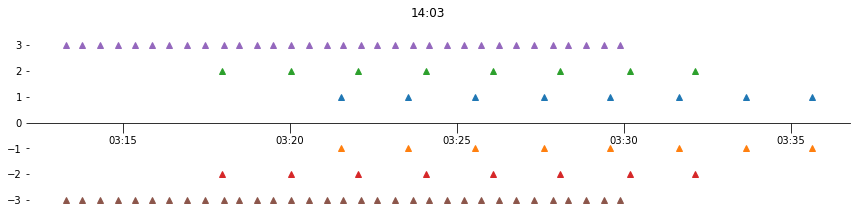

In [283]:
min_date, max_date = all_notify_logs["datetime"].min(), all_notify_logs["datetime"].max()
fig, ax = plt.subplots(figsize=(12,3))
for index,addr in enumerate(list(set(all_notify_logs["addr"].values))):
    index +=1
    logs_for_addr = all_notify_logs[all_notify_logs["addr"] == addr]
    app_logs = logs_for_addr[logs_for_addr["type"] == "Notify IN"]["datetime"].values
    hci_logs = logs_for_addr[logs_for_addr["type"] == "HCI Notify IN"]["datetime"].values
    data = matplotlib.dates.date2num(app_logs)
    data_2 = matplotlib.dates.date2num(app_logs)
    plt.plot_date(data,[index]*len(data),marker="^",label="%s-APP"%addr)
    plt.plot_date(data_2,[-1*(index)]*len(data_2),marker="^",label="%s-HCI"%addr)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m:%S'))
fig.suptitle("%s"%(min_date.strftime("%H:%m")))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.tick_params(axis='x', length=10)
plt.tight_layout()
plt.show()